# Computer Vision Task on Fashion MNIST

## Target and Analysis

The goal of the task was to perform multi-class image classification on the Fashion MNIST Dataset which contains 10 classes. T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag and Ankle boot. The images provided consist of 60,000 training images and 10,000 test images. All images provided were 28x28 grayscale images. The model that was opted for was a Convolutional Neural Network (CNN) which uses Max Pooling, with an Adam optimizer. The other parameters are provided in detail in the code cells below. The model can be improved further by augmenting the images and by including dropout layers as there was overfitting before 5 epochs (previous tests not included). Overfitting was observed due to the val_loss reaching a minimum before increasing again. It was observed that there are classes where the network had a difficulty of distinguishing between which suggests an area for improvement as well.

## Assumptions

There is an assumption that the labels provided from the dataset is correctly labelled and there was no process of data cleaning to ensure that the data provided was accurate.


### Required Libraries:

* tensorflow
* sklearn
* numpy
* matplotlib
* pandas

In [1]:
import os
import numpy as np 
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.math import confusion_matrix
from tensorflow import argmax
from sklearn.model_selection import train_test_split

from reader import get_images

## Creating a Model

Model is built using the build_model function

In [2]:
# Fixed Constants
CLASSES = 10
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
COLOR_CHANNELS = 1
CLASS_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Variables
LEARNING_RATE = 0.0001
DECAY = 1e-6

def build_model():
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        
        Dense(512, activation='relu'),
        
        Dense(CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=LEARNING_RATE, decay=DECAY)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       5

## Importing and Preprocess Data

* Training data is split into train and validation sets, a 4:1 split
* Values divided by 255 to get values between 0 and 1
* Convert inputs to *number of images, height of image, width of image, color channels*

In [3]:
val_percent = 0.2

def load_and_preprocess_data():
    (X_train, y_train), (X_test, y_test) = get_images()

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=val_percent)

    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    X_train = np.reshape(X_train, (X_train.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    X_val = np.reshape(X_val, (X_val.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1))

    return X_train, X_val, y_train, y_val, X_test, y_test

X_train, X_val, y_train, y_val, X_test, y_test = load_and_preprocess_data()


## Training and Prediction

Train and evaluate model with the train, validation and test sets, the model with the lowest validation loss is saved to run the prediction.

In [4]:
def train_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, num_epochs=5, batch_size=32, callbacks=None):
    model_history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    
    print('Training data:' )
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("Training : loss %.3f - acc %.3f" % (loss, acc))
    print('Cross-validation data:')
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("Cross-val: loss %.3f - acc %.3f" % (loss, acc))
    print('Test data:')
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print("Testing  : loss %.3f - acc %.3f" % (loss, acc))

checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

train_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks=checkpoint)

Epoch 1/5
1500/1500 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8484
Epoch 00001: val_loss improved from inf to 0.31441, saving model to model.h5
1500/1500 [==============================] - 210s 140ms/step - loss: 0.4170 - accuracy: 0.8484 - val_loss: 0.3144 - val_accuracy: 0.8832
Epoch 2/5
1500/1500 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9059
Epoch 00002: val_loss improved from 0.31441 to 0.26011, saving model to model.h5
1500/1500 [==============================] - 202s 134ms/step - loss: 0.2565 - accuracy: 0.9059 - val_loss: 0.2601 - val_accuracy: 0.9082
Epoch 3/5
1500/1500 [==============================] - ETA: 0s - loss: 0.1994 - accuracy: 0.9255
Epoch 00003: val_loss did not improve from 0.26011
1500/1500 [==============================] - 203s 135ms/step - loss: 0.1994 - accuracy: 0.9255 - val_loss: 0.2706 - val_accuracy: 0.9053
Epoch 4/5
1500/1500 [==============================] - ETA: 0s - loss: 0.1594 - accuracy:

## Visualisation of Predictions

* Plotting of confusion matrix of the predictions to see the performance
* Able to deduce which class the model is predicting less accurately and monitor improvements

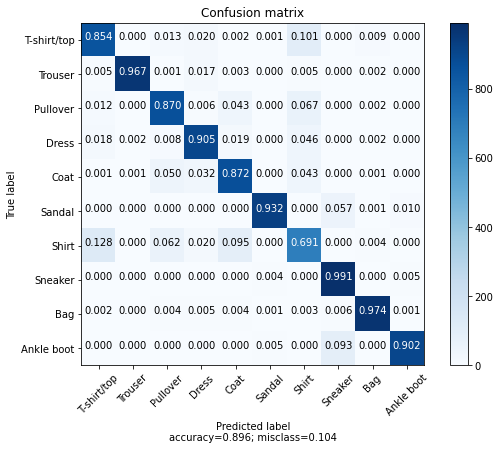

In [5]:
if os.path.exists('model.h5'):
    model = load_model('model.h5')

predictions = model.predict(X_test)
predictions = argmax(predictions, 1)

matrix = confusion_matrix(y_test, predictions)

def plot_cm(matrix, class_names, title='Confusion matrix', normalize=True):
    cm = matrix.numpy()

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

plot_cm(matrix, CLASS_LABELS)



## Conclusion

* Since the val_loss was minimum at the second epoch, data augmentation could have been done to increase the dataset to improve the classification of the dataset.
* The prediction accuracy was very low for the 'Shirt' and it was predicted as T-shirt/top for 12.8% of the 'Shirt' images provided and 10.1% vice versa.
* This suggests that trained weights are unable to classify these classes to a high accuracy.
* Drop-out of some weights might help in improving the accuracy of the model as well.